In [2]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

## 1-4 Classical computation of ground state energy
The twelve qubit state space isn't terribly large $2^{12} = 4096$, but it also isn't small. A classical computer can still diagonalize the Hamiltonian and thus compute the ground state and its associated energy. For the Open Science Prize, we don't need a full energy spectrum, just a calculation of the ground state energy. When working on your solution, remember that brute force approaches that work on 5 or 7-qubit devices may not work as well with ibmq_guadalupe's 16 qubits.

Below is an example classical calculation of the ground state energy. It will be used as a reference to your VQE results. First, the kagome lattice is defined on a graph. Second, we built the Hamiltonian from the graph edges. Finally, the expected ground state energy is calculated.

### Qiskit nature kagome unit cell
Using Qiskit nature's [`Lattice` object](https://qiskit.org/documentation/nature/tutorials/10_lattice_models.html), we can represent any spin lattice as a graph. Here we construct the unit cell of a kagome lattice by defining a list of edges between the twelve sites. This `Lattice` representation will be convenient to use when defining the $XXX$ Hamiltonian terms.

In [3]:
import rustworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
import sys
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

Now that we have the lattice geometry, we can place each term in the Hamiltonian on its corresponding edge. This is done by using the custom `HeisenbergModel` found in the heisenberg_model.py file. This model is based on Qiskit Nature's [`IsingModel` class](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.hamiltonians.IsingModel.html) . It places $XX + YY + ZZ$ on each edge of the lattice (per the Hamiltonian's definition).

We will also need to specify how the spin-1/2 particles map to qubits. Using Qiskit nature's `LogarithmicMapper`, we can map each spin-1/2 site to a single qubit. For more information on Qiskit nature's spin mappings see [here](https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.SpinMapper.html#spinmapper).

In [4]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

### Compute ground state energy
With the Hamiltonian in hand, we can now calculate the expected ground state and its energy. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

Below is an example calculation of finding the lowest 3 energies ($k=3$) of the system using the second method. Remember that for this year's Prize, you will only need to use VQE to find the ground state energy and not any excited state energies.

You'll note that -18 is found twice. This means there are actually two ground states for this system. The -16.96 energy is the first excited state, which is not part of this year's challenge. **For this year's Prize, we will only be judging based off the measured ground state energy. This means it does not matter which of the two ground states, or combination of them, your VQE implementation finds.**

## 2-1 VQE with local runtime primitives

To compute the ground state energy using VQE, we first pick an appropriate device. This year's Prize will use ibmq_guadalupe which has 16 qubits. This is 4 extra qubits than the Hamiltonian, so we will need to "inflate" the Hamiltonian with identity operators so we can measure 12 qubit Hamiltonian's energy expectation value on a 16 qubit device.
After inflating the Hamiltonian, the anstaz and classical optimizer components are built up. Finally, a class is defined to bring everything together for the VQE algorithm, and it's executed on a local simulator.

The code below is largely based off of this example [tutorial](https://github.com/mberna/qce22-qiskit-runtime-tutorial/blob/main/docs/tutorials/Building%20algorithms%20with%20Qiskit%20Runtime.ipynb) of using qiskit runtime primitives from IEEE week. Feel free to read through to learn more about qiskit runtime and VQE.

## 2-2 Qiskit runtime

[Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) is a paradigm which brings classical and quantum computing resources closer together--speeding up quantum algorithms especially variational ones. We will be using runtime because of its [speed boost](https://research.ibm.com/blog/120x-quantum-speedup) relative to the traditional way quantum circuits are executed using qiskit. In this notebook, we'll demonstrate an example VQE executed with qiskit runtime, but we encourage you to get a deeper understanding of the tool by checking out an overview of qiskit runtime and some tutorials on the [qiskit docs section on runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) as well as the IBM [research blog](https://research.ibm.com/blog/qiskit-runtime-capabilities-integration).

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [6]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
#IBMQ.load_account() # Load account from disk
#provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
#guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

#Noisy simulator backend
noisy_sim = FakeGuadalupe()
from qiskit.opflow import Zero, One, I, X, Y, Z, PauliSumOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
#from qiskit.tools.monitor import job_monitor
#from qiskit.circuit import Parameter
backend = Aer.get_backend('qasm_simulator')

As mentioned at the beginning of this section, the system Hamiltonian is defined over 12 qubits, but ibmq_guadalupe has 16 qubits. To execute VQE on ibmq_guadalupe, we will "inflate" the Hamilontian from 12 qubits to 16 qubits to match ibmq_guadalupe, but those extra 4 qubits will not participate in the energy expectation value. Here, we've chosen the 4 qubits that won't participate to be 0, 6, 9, 15. You may pick different qubits.

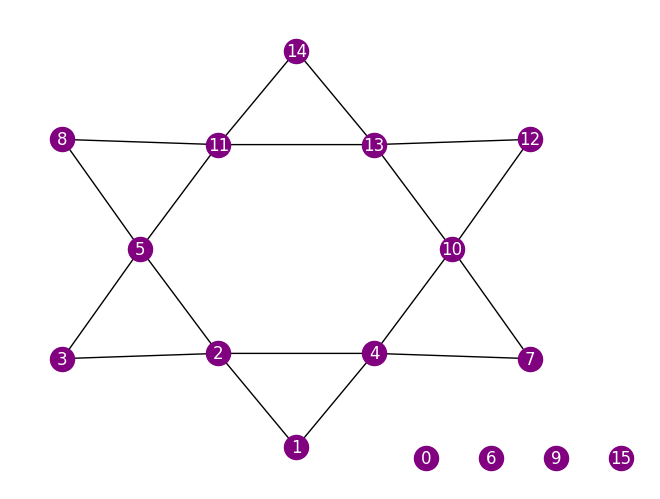

In [7]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [8]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)
heis_16
# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

## 2-3 Define an ansatz
Crafting the ansatz is critical to VQE. You may use a prebuilt ansatz from the [qiskit circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits). You may also make your own custom ansatz. Keep in mind that a custom ansatz should have no measurement gates at the end and the circuit parameters are defined by using `Parameter()` [objects](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html). We've demonstrated both options below. The ansatz can be defined over 12 qubits without needed to inflate it to 16 qubits at this point. The transpiler will take care of that later on.

Here's an example using `EfficientSU2()` to generate an ansatz

Here's an example of building a custom ansatz. We'll continue using this one for the rest of the notebook.

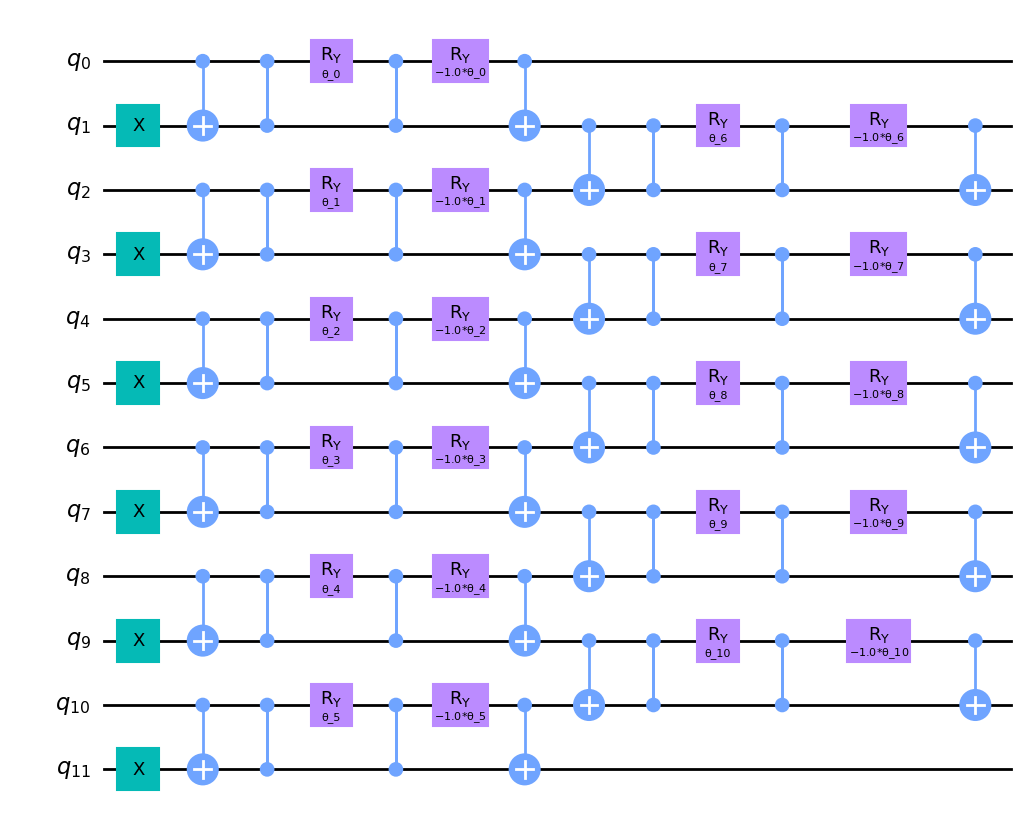

In [9]:
# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# build initial state
# ansatz_custom.h(range(0, 12, 2))
j = 0
#for i in range(12):
#    theta=Parameter('θ_' + str(j))
#    ansatz_custom.ry(theta, i)
#    j += 1

ansatz_custom.x(range(1,12,2))
# First layer
#ansatz_custom.cx(range(0, 11, 4), range(1, 12, 4))
#for i in range(3):
#    theta=Parameter('θ_' + str(j))
#    ansatz_custom.ry(theta, 4*i-3)
#    ansatz_custom.cx(4*i-3, 4*i-4)
#    ansatz_custom.ry(-1.0*theta, 4*i-3)
#    j += 1

ansatz_custom.cx(range(0, 12, 2), range(1, 12, 2))
ansatz_custom.cz(range(1, 12, 2), range(0, 11, 2))

for i in range(6):
    theta=Parameter('θ_' + str(j))
    ansatz_custom.ry(theta, 2*i)
    ansatz_custom.cz(2*i, 2*i+1)
    ansatz_custom.ry(-1.0*theta, 2*i)
#    ansatz_custom.ry(theta, 2*i+6)
#    ansatz_custom.cz(2*i+6, 2*i+7)
#    ansatz_custom.ry(-1.0*theta, 2*i+6)
    j += 1

ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))

ansatz_custom.cx(range(1, 11, 2), range(2, 12, 2))
for i in range(5):
    theta=Parameter('θ_' + str(j))
    ansatz_custom.cz(2*i+2, 2*i+1)
    ansatz_custom.ry(theta, 2*i+1)
    ansatz_custom.cz(2*i+2, 2*i+1)
    ansatz_custom.ry(-1.0*theta, 2*i+1)
#    ansatz_custom.ry(theta, 2*i+7)
#    ansatz_custom.cz(2*i+8, 2*i+7)
#    ansatz_custom.ry(-1.0*theta, 2*i+7)
    j += 1

#theta=Parameter('θ_' + str(j))
#ansatz_custom.ry(theta, 5)
#ansatz_custom.cz(6, 5)
#ansatz_custom.ry(-1.0*theta, 5)
    
ansatz_custom.cx(range(1, 11, 2), range(2, 12, 2))

#down triangle

#for i in range(3):
#    theta=Parameter('θ_' + str(j))
#    ansatz_custom.cx(4*i-2, 4*i-1)
#    ansatz_custom.ry(theta, 4*i-1)
#    ansatz_custom.cx(4*i-1, 4*i-2)
#    ansatz_custom.ry(-1.0*theta, 4*i-1)
#    ansatz_custom.cx(4*i-2, 4*i-1)
#    j += 1
# second layer
#for i in range(12):
#    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
#    j += 1
#    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
#    j += 1
#ansatz_custom.cz(range(0, 11), range(1, 12))


ansatz_custom.draw(fold=250)

### Match qubit layout
The ansatz is currently defined over 12 qubits, but it will be executed on guadalupe which has 16 qubits. To make the ansatz compatible with guadalupe and the inflated Hamiltonian, we can specify the qubit layout on the real device using the transpiler (shown below). We exclude the four qubits with fewest neighbors.

number and type of gates in the cirucit: OrderedDict([('rz', 122), ('sx', 67), ('cx', 44), ('x', 6)])
number of parameters in the circuit: 11


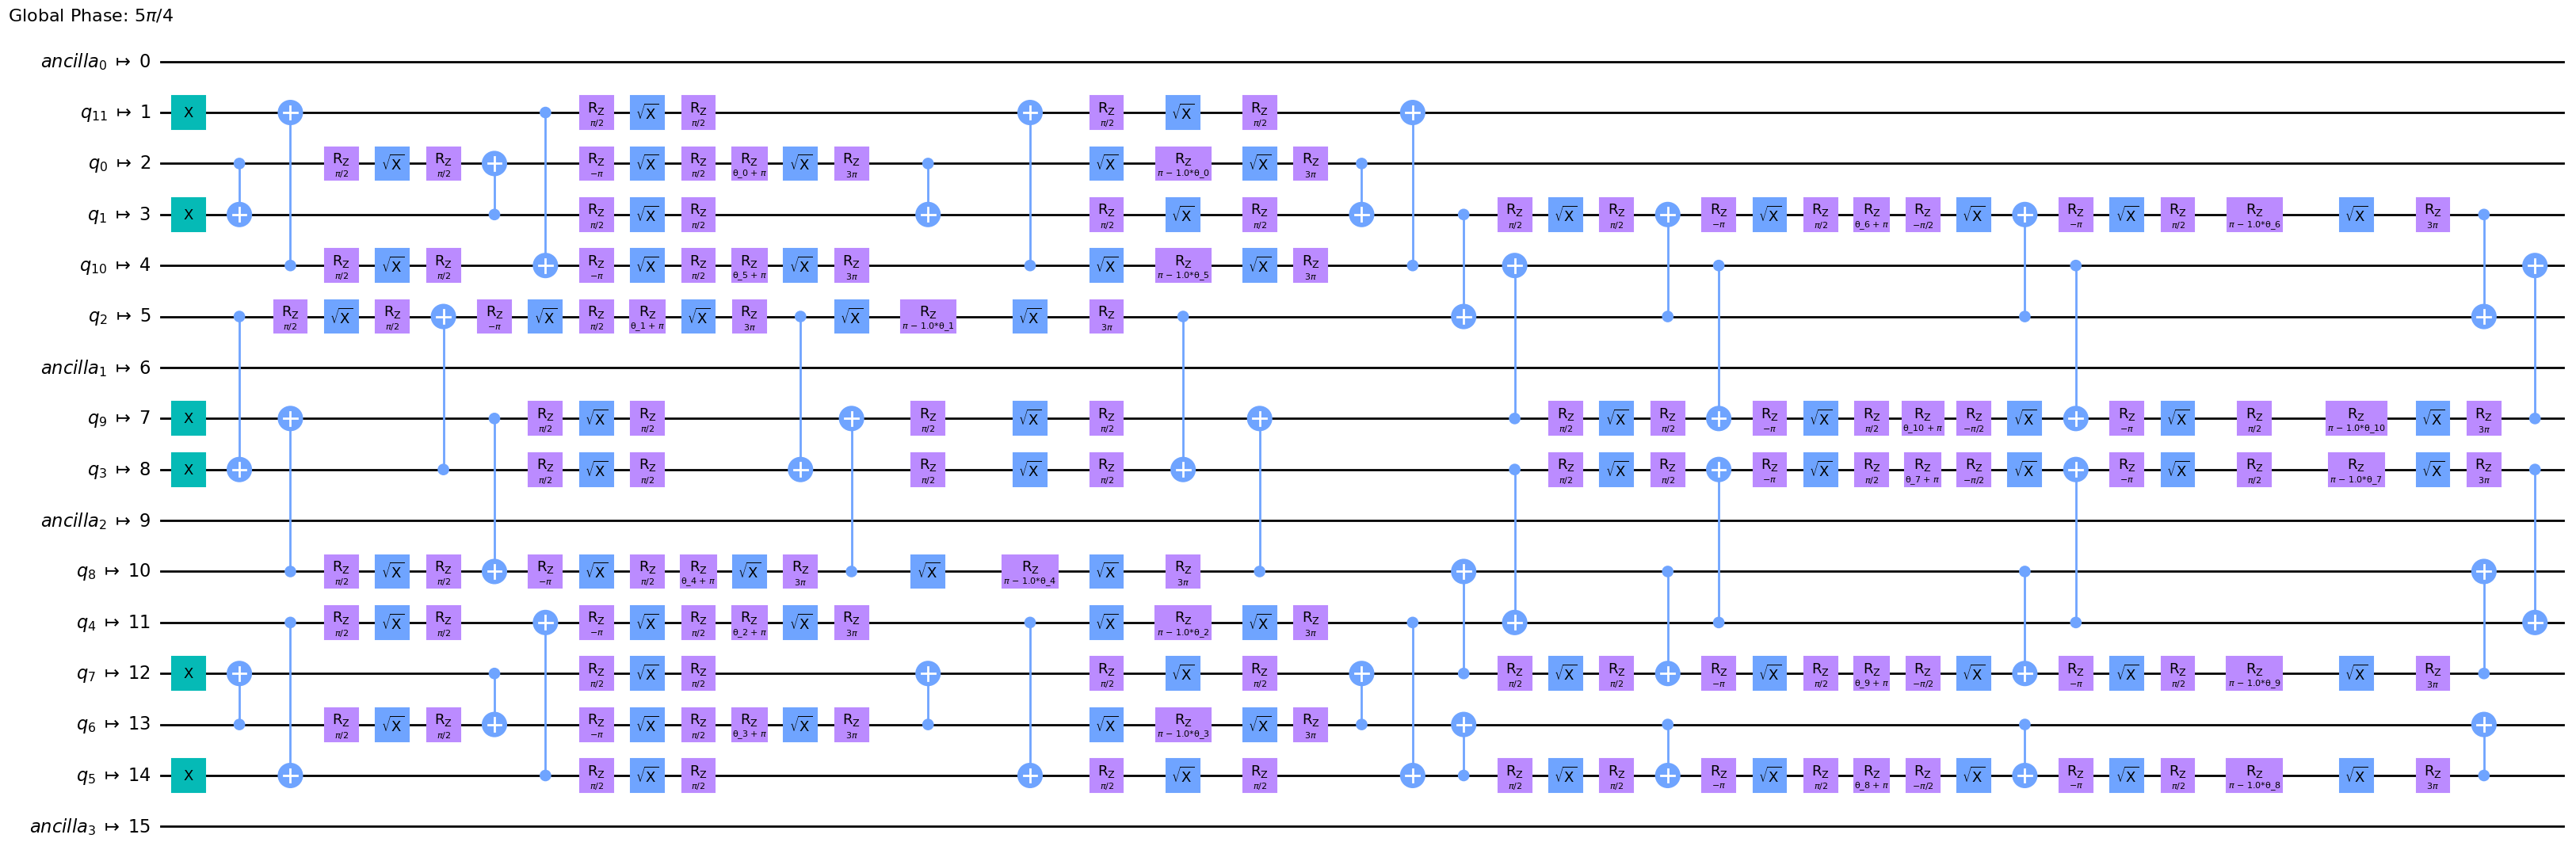

In [10]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
q_layout = [2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4, 1]
ansatz_opt = transpile(ansatz_custom, backend=noisy_sim, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=400)

## 2-4 Choose a classical optimizer
Select a [classical optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers). The classical optimizer will encounter errored and stochastic results from the quantum computer due to gate errors, measurement errors, and other noise sources as well as finite sampling affects [8]. Choose a classical optimizer that pairs well with your approach to VQE. Along with choosing a classical optimizer, picking an initial set of parameters plays a significant role in VQE. In this example, a random set of values is picked (shown in the `CustomVQE` class section 2-5).

\[8\] "Using models to improve optimizers for variational quantum algorithms" K. Sung, et al. [arXiv:2005.11011v2](https://arxiv.org/abs/2005.11011v2) [quant-ph] (2020)

In [11]:
from qiskit.algorithms.optimizers import SPSA, AQGD, GradientDescent, ADAM, QNSPSA

optimizer = GradientDescent(maxiter=50, learning_rate=0.2)
#optimizer = SPSA(maxiter=100, second_order=True)

## 2-5 Define custom VQE program
The VQE calculation can be efficiently orchestrated between the quantum and classical computer using qiskit's [primitives](https://qiskit.org/documentation/apidoc/primitives.html). Below is a simple example of using the [Estimator primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-estimator) with your computer as a local simulator of a quantum computer. It's convenient to bring the components of VQE together into a custom class which we've called `CustomVQE`.

If you want more control over the measurement results and how the expectation values are computed, use the [Sampler primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-sampler) which will output the probabilities (or quasi-probabilities) of every measured state instead of expectation values.

In [12]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
#        x0 =np.pi/4*0.0
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result


New: Making the effective Hamiltonian
We transform the given Hamiltonian to another representation by using grobal unitary transformation based on the optimized ansatz

New: Making the effective Hamiltonian
We transform the given Hamiltonian to another representation by using grobal unitary transformation based on the optimized ansatz

In [13]:
# Build effective Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

### Callback
It's important to know what's going on between the classical and quantum computer during the optimization. What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?

Defining a callback function gives us a chance to peek in. A simple callback method is defined below. See [this tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html) for more information and be sure to read the classical [optimizers' docs](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for what specific values can be extracted during optimization. For example [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) returns: (nfev, parameters, value, stepsize, accepted).

In [14]:
# Define a simple callback function
intermediate_info = []
def callback(value):
    intermediate_info.append(value)
    print(value)

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [15]:
from qiskit.primitives import Estimator

In [16]:
optimizer = GradientDescent(maxiter=500, learning_rate=0.1, tol=10e-3)
#optimizer = ADAM(maxiter=50, lr=0.2)z

class TerminationChecker:

    def __init__(self, N : int):
        self.N = N
        self.values = []

    def __call__(self, nfev, parameters, value, stepsize, accepted) -> bool:
        self.values.append(value)

        if len(self.values) > self.N:
            last_values = self.values[-self.N:]
            pp = np.polyfit(range(self.N), last_values, 1)
            slope = pp[0] / self.N

            if slope > 0:
                return True
        return False

#optimizer = SPSA(maxiter=200, last_avg=20, resamplings=1)#, termination_checker=TerminationChecker(50))
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
result = custom_vqe.compute_minimum_eigenvalue(ham_16)

print(result)
print(result.optimal_parameters)

-9.109916801837336
-9.13777774323319
-9.14987468044955
-9.088616942741579
-9.150633306815111
-9.144980977037791
-9.136283797674134
-9.148522376733268
-9.091101071085065
-9.08180598626219
-9.095118806160103
-9.088427631125148
-15.83956599337421
-15.841129878397993
-15.846463132558437
-15.83989950270863
-15.839705361571488
-15.8612626263677
-15.842253869358682
-15.863728560148205
-15.845459046797066
-15.825682393269055
-15.818994297267881
-15.815451870327056
-17.532066871561252
-17.53465473711531
-17.528783544016648
-17.53468581388357
-17.528408800428327
-17.53715401894339
-17.53269039990614
-17.540445155158505
-17.534975917720676
-17.530416733207627
-17.517350165633747
-17.522875501265485
-17.841168312960217
-17.84273909435811
-17.839668792501893
-17.842581281766538
-17.835550933256823
-17.839552779003224
-17.841583988336335
-17.843003281198484
-17.843444090931126
-17.839165169744316
-17.834120456522562
-17.83916681497121
-17.926559789827458
-17.92773039394634
-17.92537159930753
-17.927

In [62]:
import pickle
with open("pkls/result.pkl", "wb") as f:
    pickle.dump(result, f)
with open("pkls/result.pkl", "rb") as f:
    result = pickle.load(f)

In [63]:
from utils import *
from heisenberg_model import HeisenbergModel
#optimizer = SPSA(maxiter=100, second_order=True)

import math
import sympy

H=Hamiltonian({'ZZIIIIIIIIII':1.0, 'IZZIIIIIIIII':1.0, 'IZIZIIIIIIII':1.0, 'IIZZIIIIIIII':1.0, 'IIIZZIIIIIII':1.0, 'IIIZIZIIIIII':1.0, 'IIIIZZIIIIII':1.0, 'IIIIIZZIIIII':1.0,
               'IIIIIZIZIIII':1.0, 'IIIIIIZZIIII':1.0, 'IIIIIIIZZIII':1.0, 'IIIIIIIZIZII':1.0, 'IIIIIIIIZZII':1.0, 'IIIIIIIIIZZI':1.0, 'ZIIIIIIIIIIZ':1.0, 'IZIIIIIIIIIZ':1.0,
               'IIIIIIIIIZIZ':1.0, 'IIIIIIIIIIZZ':1.0, 'YYIIIIIIIIII':1.0, 'IYYIIIIIIIII':1.0, 'IYIYIIIIIIII':1.0, 'IIYYIIIIIIII':1.0, 'IIIYYIIIIIII':1.0, 'IIIYIYIIIIII':1.0,
               'IIIIYYIIIIII':1.0, 'IIIIIYYIIIII':1.0, 'IIIIIYIYIIII':1.0, 'IIIIIIYYIIII':1.0, 'IIIIIIIYYIII':1.0, 'IIIIIIIYIYII':1.0, 'IIIIIIIIYYII':1.0, 'IIIIIIIIIYYI':1.0,
               'YIIIIIIIIIIY':1.0, 'IYIIIIIIIIIY':1.0, 'IIIIIIIIIYIY':1.0, 'IIIIIIIIIIYY':1.0, 'XXIIIIIIIIII':1.0, 'IXXIIIIIIIII':1.0, 'IXIXIIIIIIII':1.0, 'IIXXIIIIIIII':1.0,
               'IIIXXIIIIIII':1.0, 'IIIXIXIIIIII':1.0, 'IIIIXXIIIIII':1.0, 'IIIIIXXIIIII':1.0, 'IIIIIXIXIIII':1.0, 'IIIIIIXXIIII':1.0, 'IIIIIIIXXIII':1.0, 'IIIIIIIXIXII':1.0,
               'IIIIIIIIXXII':1.0, 'IIIIIIIIIXXI':1.0, 'XIIIIIIIIIIX':1.0, 'IXIIIIIIIIIX':1.0, 'IIIIIIIIIXIX':1.0, 'IIIIIIIIIIXX':1.0})
A=Hamiltonian({"I"*12:1.0})
H=A*H*A

print(H)

{'ZZIIIIIIIIII': 1.0, 'IZZIIIIIIIII': 1.0, 'IZIZIIIIIIII': 1.0, 'IIZZIIIIIIII': 1.0, 'IIIZZIIIIIII': 1.0, 'IIIZIZIIIIII': 1.0, 'IIIIZZIIIIII': 1.0, 'IIIIIZZIIIII': 1.0, 'IIIIIZIZIIII': 1.0, 'IIIIIIZZIIII': 1.0, 'IIIIIIIZZIII': 1.0, 'IIIIIIIZIZII': 1.0, 'IIIIIIIIZZII': 1.0, 'IIIIIIIIIZZI': 1.0, 'ZIIIIIIIIIIZ': 1.0, 'IZIIIIIIIIIZ': 1.0, 'IIIIIIIIIZIZ': 1.0, 'IIIIIIIIIIZZ': 1.0, 'YYIIIIIIIIII': 1.0, 'IYYIIIIIIIII': 1.0, 'IYIYIIIIIIII': 1.0, 'IIYYIIIIIIII': 1.0, 'IIIYYIIIIIII': 1.0, 'IIIYIYIIIIII': 1.0, 'IIIIYYIIIIII': 1.0, 'IIIIIYYIIIII': 1.0, 'IIIIIYIYIIII': 1.0, 'IIIIIIYYIIII': 1.0, 'IIIIIIIYYIII': 1.0, 'IIIIIIIYIYII': 1.0, 'IIIIIIIIYYII': 1.0, 'IIIIIIIIIYYI': 1.0, 'YIIIIIIIIIIY': 1.0, 'IYIIIIIIIIIY': 1.0, 'IIIIIIIIIYIY': 1.0, 'IIIIIIIIIIYY': 1.0, 'XXIIIIIIIIII': 1.0, 'IXXIIIIIIIII': 1.0, 'IXIXIIIIIIII': 1.0, 'IIXXIIIIIIII': 1.0, 'IIIXXIIIIIII': 1.0, 'IIIXIXIIIIII': 1.0, 'IIIIXXIIIIII': 1.0, 'IIIIIXXIIIII': 1.0, 'IIIIIXIXIIII': 1.0, 'IIIIIIXXIIII': 1.0, 'IIIIIIIXXIII': 1.0, 'IIIIIIIXIXI

In [64]:
#operate cz
for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
    

for i in range(5):
    if 0.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    elif 0.75*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(9-2*i)+"Y"+"I"*(2*i+2):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    else:
        H=H

for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(5):
    if 0.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    elif 0.75*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(9-2*i)+"Y"+"I"*(2*i+2):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    else:
        H=H
for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
    
#operate cz
for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"XI"+"I"*(10-2*i):0.5,"I"*(2*i)+"XZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
    

for i in range(6):
    if 0.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    elif 0.75*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(10-2*i)+"Y"+"I"*(2*i+1):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    else:
        H=H

for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZI"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(6):
    if 0.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    elif 0.75*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(10-2*i)+"Y"+"I"*(2*i+1):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    else:
        H=H
        
for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZI"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"XI"+"I"*(10-2*i):0.5,"I"*(2*i)+"XZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
        
        
print(H)

{'IIIIIIIIIIII': 0.5, 'IXIIIIIIIIII': 0.5, 'IIZIIIIIIIII': 0.5, 'IXZIIIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIXIIIIIIII': 0.5, 'IIIIZIIIIIII': 0.5, 'IIIXZIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIXIIIIII': 0.5, 'IIIIIIZIIIII': 0.5, 'IIIIIXZIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIXIIII': 0.5, 'IIIIIIIIZIII': 0.5, 'IIIIIIIXZIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIIIXII': 0.5, 'IIIIIIIIIIZI': 0.5, 'IIIIIIIIIXZI': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIZIIIIIIIII': 0.5, 'IZIIIIIIIIII': 0.5, 'IZZIIIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIZIIIIIII': 0.5, 'IIIZIIIIIIII': 0.5, 'IIIZZIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIZIIIII': 0.5, 'IIIIIZIIIIII': 0.5, 'IIIIIZZIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIIZIII': 0.5, 'IIIIIIIZIIII': 0.5, 'IIIIIIIZZIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIIIIZI': 0.5, 'IIIIIIIIIZII': 0.5, 'IIIIIIIIIZZI': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIZIIIIIIIII': 0.5, 'IZIIIIIIIIII': 0.5, 'IZZIIIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIZIIIIIII': 0.5, 'IIIZIIIIII

In [65]:
#apply for the 16 qubits device 


Heff=Hamiltonian({"I"*16:0.0})
for operator, coeff in H.items():
    operator=operator+"I"*4
    operator_dum=Hamiltonian({"I"*16:1.0})
    j=0
    for i in q_layout:
        operator_dum=operator_dum*Hamiltonian({"I"*(i)+operator[j]+"I"*(15-i):1.0})
        j+=1
    Heff=Heff+operator_dum*Hamiltonian({"I"*16:round(coeff)})

print(Heff)

n=0
Heff_operator=""

Heff_coeff= np.zeros((55))

for operator, coeff in Heff.items():
    Heff_operator= Heff_operator + operator if Heff_operator == "" else Heff_operator+" "+operator 
    Heff_coeff[n]=coeff
    print("operator=",operator)
    print("coeff[",n,"]",Heff_coeff[n])
    n+=1

Heff_operator2 = Heff_operator.split()
    
import logging
import numpy as np
from fractions import Fraction
from typing import Optional

from qiskit_nature.second_q.operators import SpinOp
from qiskit_nature.problems.second_quantization.lattice.lattices import Lattice
from qiskit_nature.problems.second_quantization.lattice.models.lattice_model import LatticeModel

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

#SparsePauliOp(Heff_operator2,np.array(Heff_coeff))
ham_eff=PauliSumOp(SparsePauliOp(Heff_operator2,np.array(Heff_coeff)))

#ham_eff=SpinOp({"X_0":0.0},spin=Fraction(1,2), num_spins=16)
#for operator, coeff in Heff.items():
#    operator_dum2=""
##    for i in range(len(operator)):
 #       if operator[i]=="I":
#            continue
#        else:
#            operator_dum2 += operator[i] + "_" + str(i) if operator_dum2 == "" else " " + operator[i] + "_" + str(i)
#    ham_eff = ham_eff + SpinOp({operator_dum2: coeff}, num_spins=16)

print(ham_eff)
print("upforward is ham_eff")


{'IIIIIIIIIIIIIIII': 0.0, 'IIZZIZIIZIIIIIII': 1.00000000000000, 'IIIIIIIIIIIIZIII': 1.00000000000000, 'IIIIIIIIIIXIZIII': 1.00000000000000, 'IIIIIIIIIIIIIXII': -1.00000000000000, 'IIIIIIIZIIIIIIII': 1.00000000000000, 'IIIIXIIZIIIIIIII': 1.00000000000000, 'IIIIIIIIIIXIIIII': -1.00000000000000, 'IZIIZIIZIIIIIIII': 1.00000000000000, 'IZIIZIIIIIIIIIII': 1.00000000000000, 'IZZIIIIIIIIIIIII': 1.00000000000000, 'IZIZIZIIZIIIIIII': 1.00000000000000, 'IIYYIIIIIIIIIIII': 1.00000000000000, 'IYYIIIIIIIIIIIII': 1.00000000000000, 'IYIYIIIIIIIIIIII': 1.00000000000000, 'IIXXIZIIZIIIIIII': 1.00000000000000, 'IIIXIXIIXIIZIIZI': 1.00000000000000, 'IIIYIIIIYIIZIIZI': 1.00000000000000, 'IIIIIYIIYIIXIZXI': -1.00000000000000, 'IIIIIYIIXIIIIZYI': 1.00000000000000, 'IIIIIIIIIIZYXZYI': -1.00000000000000, 'IIIIIIIIIIZYXYXI': 1.00000000000000, 'IIIIZIIXIIZIXIII': 1.00000000000000, 'IIIIZIIXIIYIYIII': 1.00000000000000, 'IXXIIIIIIIIIIIII': 1.00000000000000, 'IXIXIZIIZIIIIIII': 1.00000000000000, 'IXIIZIIXIIIIIIII': 

In [66]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_eff])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)
print("VQE Lunning...")
# Run the custom VQE function and monitor execution time
result = custom_vqe.compute_minimum_eigenvalue(ham_eff)

print(result)
print(H)

VQE Lunning...
-11.541199919685418
-11.576547440636
-11.55443343891974
-11.535322882786208
-11.532783461547812
-11.542107733405395
-11.577266579181696
-11.567444376808364
-11.53804423934255
-11.512407754396808
-11.559403296720806
-11.540650580764222
-15.07413926584655
-15.088520004868775
-15.07753436200616
-15.059522670282195
-15.082329752006814
-15.071129257662289
-15.089730715666885
-15.081492054698977
-15.070491272767704
-15.057650416006076
-15.093202128353939
-15.071367277660649
-16.297053384558847
-16.30091974143749
-16.29807498569437
-16.28832013988088
-16.30273833870279
-16.295296117849198
-16.30355079405335
-16.301820910702798
-16.294960711040822
-16.28627849695242
-16.31623497091875
-16.29601478584041
-16.881847923444404
-16.882793913445845
-16.882191063029417
-16.878968210688647
-16.883878855137617
-16.88411063872497
-16.885569983528747
-16.883714607427702
-16.88066670963929
-16.87642140227082
-16.89967272397193
-16.881799976600043
-17.241627326007517
-17.241814693241977
-17.

In the print out above, the ground state energy is under "eigenvalue", and the optimal choice of parameters that goes with that energy is under "optimal_parameters". Let's plot the energy convergence data the callback function acquired.

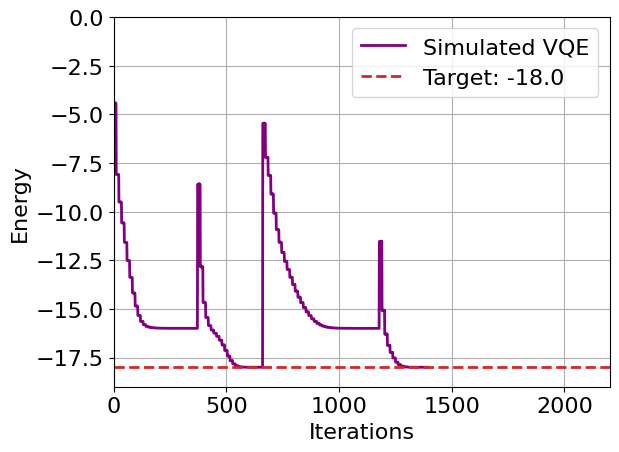

In [67]:
# Figureを設定
fig = plt.figure()

# グラフ描画領域を追加
ax = fig.add_subplot(111)

ax.set_ylim(-19.00,0.00)
ax.set_xlim(0,2200)

plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

The true ground state energy is -18.0. As a metric for how well the VQE found the ground state energy, we will compute the relative difference between -18.0 and what we just achieved with VQE. This will be the metric of performance in the judging criteria, though it's important to note that it's not the only useful metric when working with VQE. Remember that the lower the relative error the higher you will score.

In [142]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -17.9988409711
Relative error: 0.00006439


## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [143]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel='ibm_quantum')

In [144]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [145]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [146]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [147]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.time()
print(f'execution time (s): {end - start:.2f}')

Traceback (most recent call last):
  Cell In[147], line 7
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
NameError: name 'callback_real' is not defined

Use %tb to get the full traceback.


In [130]:
# # Setup Estimator (standard method)
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # Set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
#     # Run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

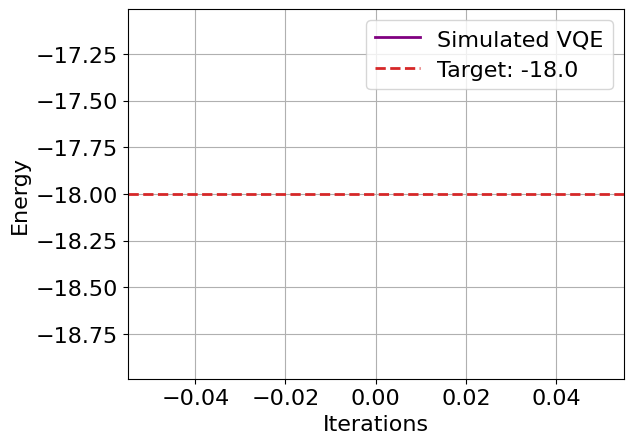

In [131]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [74]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -5.8767353505
Relative error: 0.67351470


## 3-2 Qiskit runtime Real backend (ibmq_guadalupe)

If our `qiskit_ibm_runtime` code is working on the cloud simulator backend, we can simply change the backend to the ibmq_guadalupe to run on the real backend. This may take a couple hours. Your performance score will be determined by the calculated relative error between the true ground state energy of -18.0 and the measured energy from the real ibmq_guadalupe backend.

In [75]:
# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-community/ibmquantumawards/open-science-22',
)

backend = 'ibmq_guadalupe'

/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:448: UserWarning: Default hub/group/project ibm-q-community/ibmquantumawards/open-science-22 not found for the account and is ignored.
  warnings.warn(


In [76]:
# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [77]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [78]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.time()
print(f'execution time (s): {end - start:.2f}')


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 2...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 3...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 4...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 5...

Creating new session...


Something went wrong...


ERROR MESSAGE:
'Backend ibmq_guadalupe cannot be found in any hub/group/project for this account.'


Failed to create job.
Starting trial number 6...

Creating n

In [79]:
# # Setup Estimator
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
#     # run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

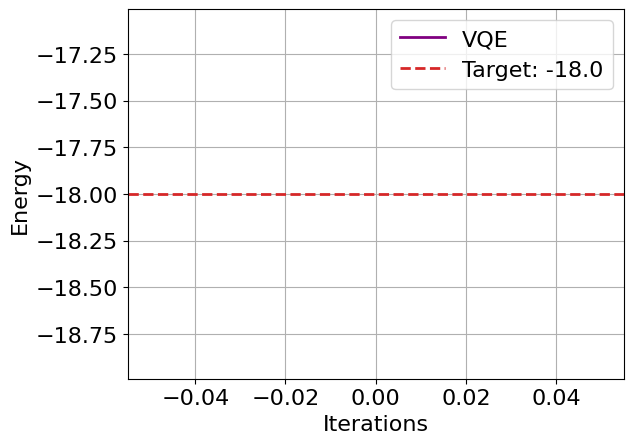

In [80]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## 3-3 Performance Score
Compute the relative error between the expected ground state energy and the VQE result.

In [81]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

Traceback (most recent call last):
  Cell In[81], line 2
    computed_gse = intermediate_info_real_backend[-1]
IndexError: list index out of range

Use %tb to get the full traceback.


# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [153]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.9.1'

In [154]:
import qiskit.tools.jupyter
%qiskit_version_table